<a href="https://colab.research.google.com/github/ShovalBenjer/Titanic---Machine-Learning-from-Disaster/blob/main/Machine_learning_project_phase_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Shoval Benjer id 319037404
# Nadav Falkowski id 207446543
link to kaggle account - https://www.kaggle.com/shovalbenjer

# **TL;DR - Phase 3 of Project**
 The data was transformed (skewed features) for better distribution,split into training and validation sets, followed by feature scaling and selection using RFE and RFA with LightGBM. Models (KNN, LDA, QDA) were optimized using Optuna hyperparameter tuning. A Voting Classifier with the best models was evaluated, achieving a cross-validation mean accuracy of 80.8%, and validation accuracy of 79.9%.
Optimized model accuracy: 79.9%
Phase 1 submission: 0.7703
Phase 3 submission: 0.7822

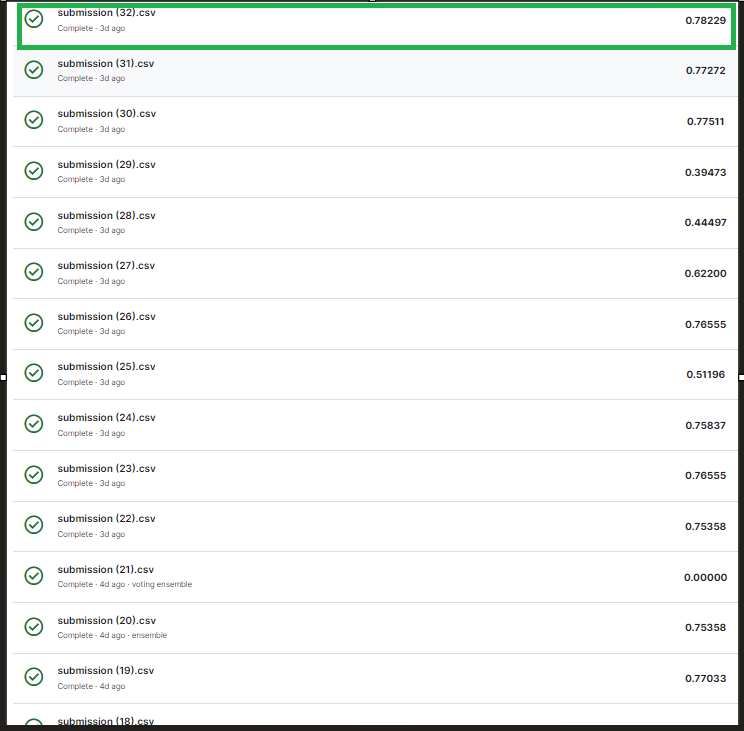

We finished top 17% although restricted to certian models.
we believe in future projects we will use unsupervised learning/gradient boosting methods we can improve score and reach minimum top 2%

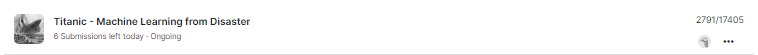

# **Intro** - Understanding the Titanic Disaster: A Data Science Challenge
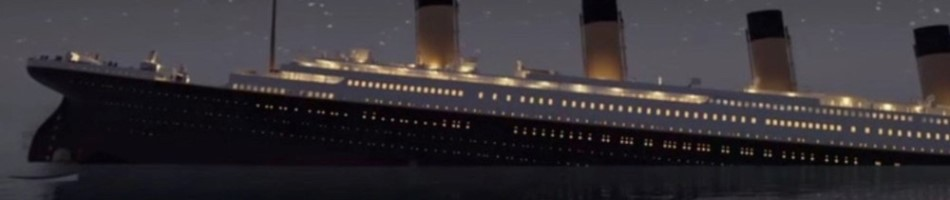


On April 15, 1912, the Titanic met its tragic end after striking an iceberg. The disaster claimed the lives of 1,502 out of the 2,224 passengers and crew members, largely due to a shortage of lifeboats. While luck played a role in who survived, certain groups appeared to have higher survival rates. This challenge seeks to answer the question, "Which types of people were more likely to survive?" We will explore this by employing a regression model.








# **Phase 1 (Level 1 implemention)**

# **Setup and Load Data**



In [ ]:
!pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.6 MB/s eta 0:00:00


In [ ]:
!pip install optuna
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score, precision_score, roc_auc_score, confusion_matrix,accuracy_score, ConfusionMatrixDisplay,log_loss
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.8 MB/s eta 0:00:00


In [ ]:
# Load the dataset
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Display the first few rows of the dataset
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)        # Prevent line breaks
print("Train Data Head:")
print(train_data.head())

# Display descriptive statistics
print("\nTrain Data Description:")
print(train_data.describe())

# Display data types and non-null counts
print("\nTrain Data Info:")
print(train_data.info())

Train Data Head:
   PassengerId  Survived  Pclass                                               Name     Sex   Age  \
0            1         0       3                            Braund, Mr. Owen Harris    male  22.0   
1            2         1       1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
2            3         1       3                             Heikkinen, Miss. Laina  female  26.0   
3            4         1       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
4            5         0       3                           Allen, Mr. William Henry    male  35.0   

   SibSp  Parch            Ticket     Fare Cabin Embarked  
0      1      0         A/5 21171   7.2500   NaN        S  
1      1      0          PC 17599  71.2833   C85        C  
2      0      0  STON/O2. 3101282   7.9250   NaN        S  
3      1      0            113803  53.1000  C123        S  
4      0      0            373450   8.0500   NaN        S  

Train Data Desc

# **Exploratory Data Analysis (EDA)**


Missing Values:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


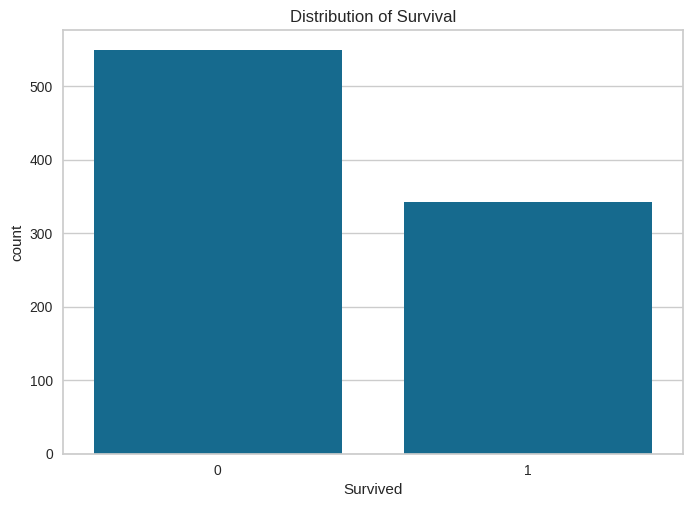

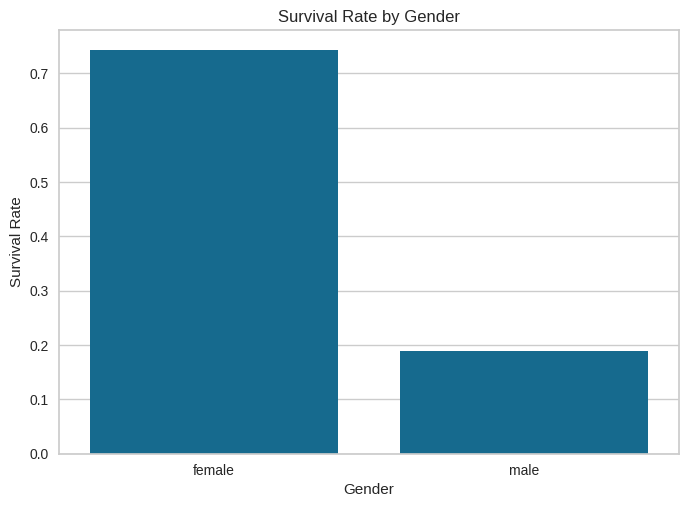

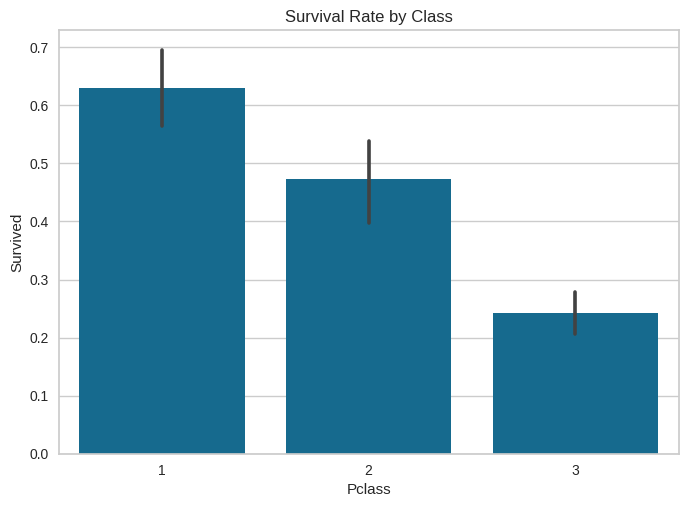

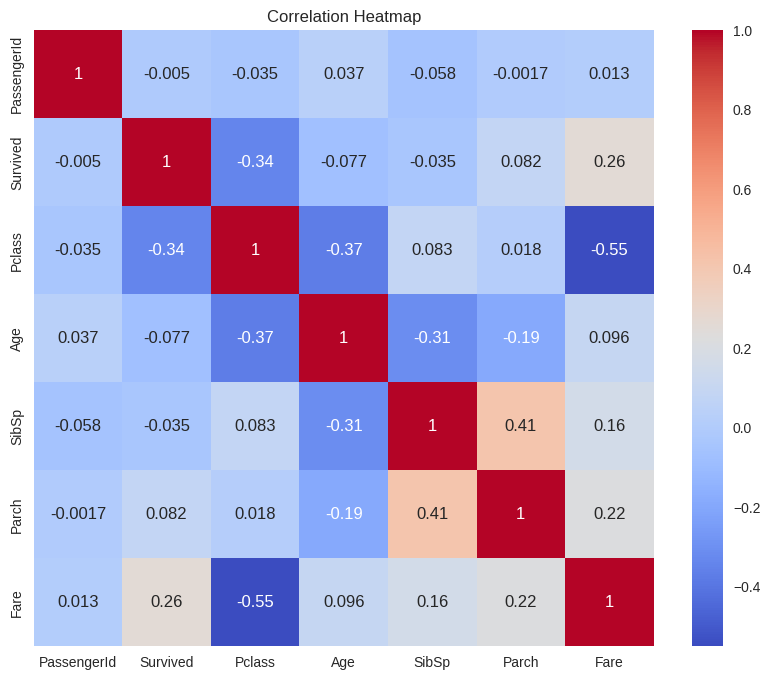

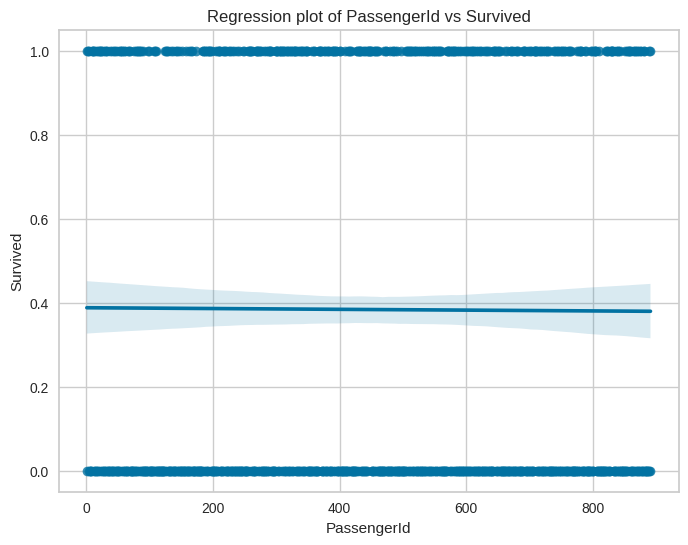

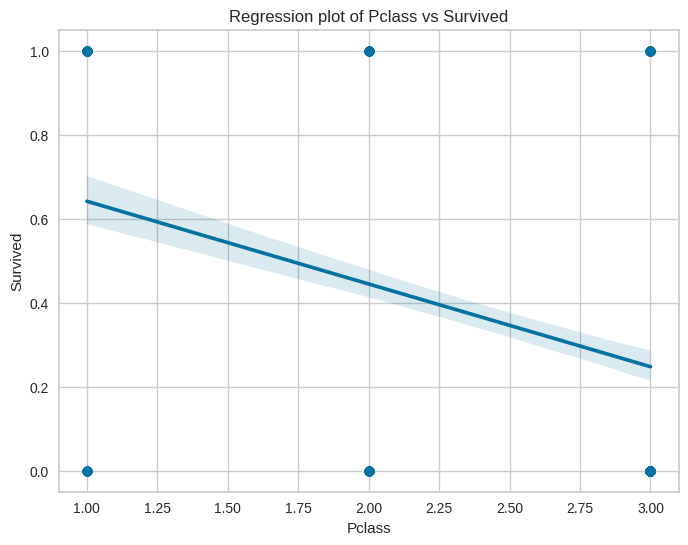

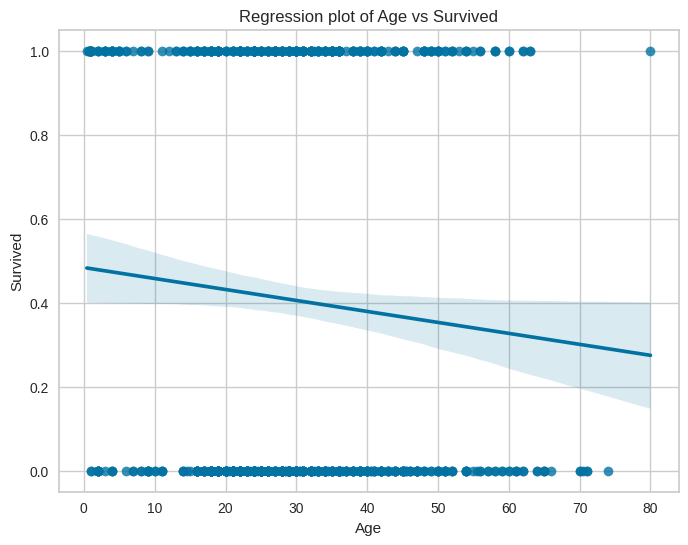

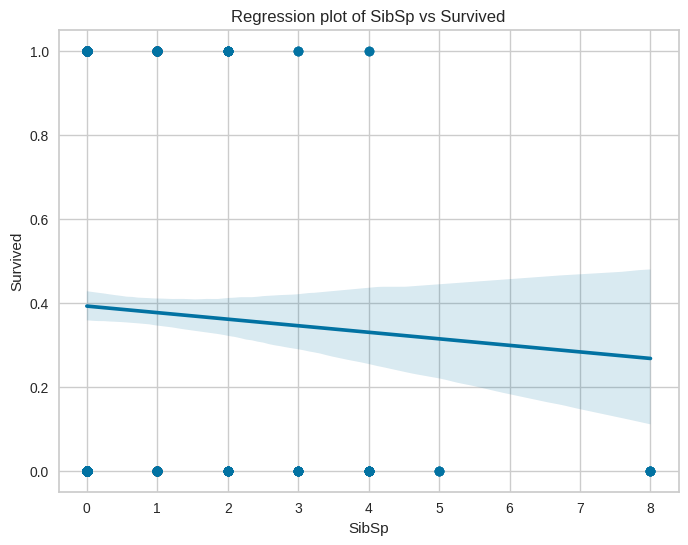

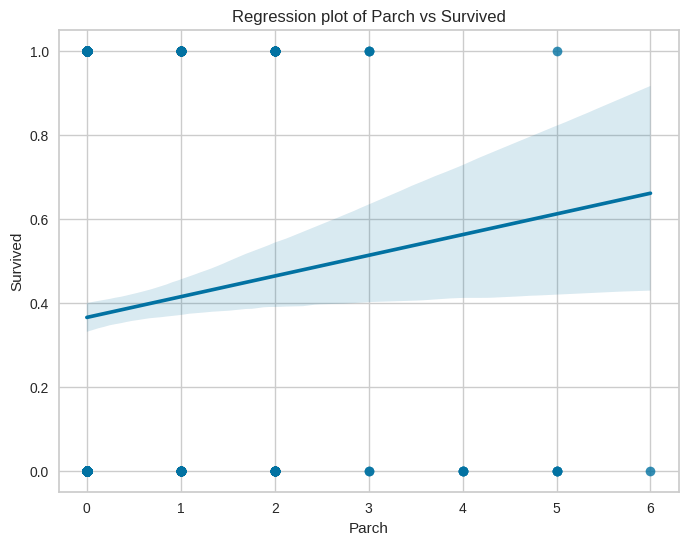

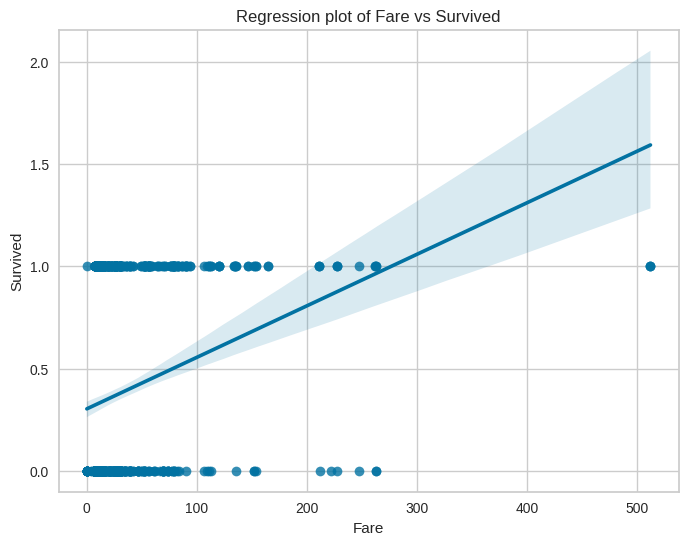

In [ ]:
# Check for missing values
print("\nMissing Values:")
print(train_data.isnull().sum())

# Visualize the distribution of survival
sns.countplot(x='Survived', data=train_data)
plt.title('Distribution of Survival')
plt.show()

# Visualize survival rate by gender
# Use the 'Sex' column directly
survival_rate_by_gender = train_data.groupby('Sex')['Survived'].mean().reset_index()
sns.barplot(x='Sex', y='Survived', data=survival_rate_by_gender)
plt.title('Survival Rate by Gender')
plt.ylabel('Survival Rate')
plt.xlabel('Gender')
plt.show()

# Visualize survival rate by class
sns.barplot(x='Pclass', y='Survived', data=train_data)
plt.title('Survival Rate by Class')
plt.show()

# Select only numeric columns for the correlation heatmap
numeric_cols = train_data.select_dtypes(include=[np.number])

# Heatmap of correlations
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Define a function to plot regression plots for numeric columns only
def reg_plot(df, column):
    numeric_cols = df.select_dtypes(include=[np.number])
    for col in numeric_cols.columns:
        if col != column:
            plt.figure(figsize=(8, 6))
            sns.regplot(x=numeric_cols[col], y=numeric_cols[column])
            plt.title(f'Regression plot of {col} vs {column}')
            plt.ylabel(column)
            plt.xlabel(col)
            plt.show()

# Assuming 'train_data' is your DataFrame and 'Survived' is the target column
reg_plot(train_data, 'Survived')


From the visualizations, we can see that most passengers didn't survive the Titanic disaster. Women and those in higher classes (first and second) had a better chance of survival. Additionally, passengers who paid higher fares also had a higher likelihood of surviving.

# **Data Preprocessing**

In [ ]:
# Fill missing values in 'Age' with the median age
train_data['Age'].fillna(train_data['Age'].median(), inplace=True)
test_data['Age'].fillna(test_data['Age'].median(), inplace=True)

# Fill missing values in 'Embarked' with the mode
train_data['Embarked'].fillna(train_data['Embarked'].mode()[0], inplace=True)

# Fill missing values in 'Fare' with the median fare (for test set)
test_data['Fare'].fillna(test_data['Fare'].median(), inplace=True)

# Drop 'Cabin' column due to high number of missing values
train_data.drop('Cabin', axis=1, inplace=True)
test_data.drop('Cabin', axis=1, inplace=True)

# Convert categorical variables into numeric
train_data = pd.get_dummies(train_data, columns=['Sex', 'Embarked'])
test_data = pd.get_dummies(test_data, columns=['Sex', 'Embarked'])

# Ensure both train and test sets have the same columns
test_data['Sex_male'] = test_data['Sex_male'].astype(int)
test_data['Embarked_C'] = test_data['Embarked_C'].astype(int)
test_data['Embarked_Q'] = test_data['Embarked_Q'].astype(int)
test_data['Embarked_S'] = test_data['Embarked_S'].astype(int)


# **Feature Selection**

In [ ]:
# Define feature columns
features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S']

# Split the data into training and validation sets
X = train_data[features]
y = train_data['Survived']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


# **Model Training and Evaluation**

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.8045
Logistic Regression F1 Score: 0.7552
Logistic Regression Precision: 0.7826
Logistic Regression ROC AUC: 0.8813
Logistic Regression Confusion Matrix:


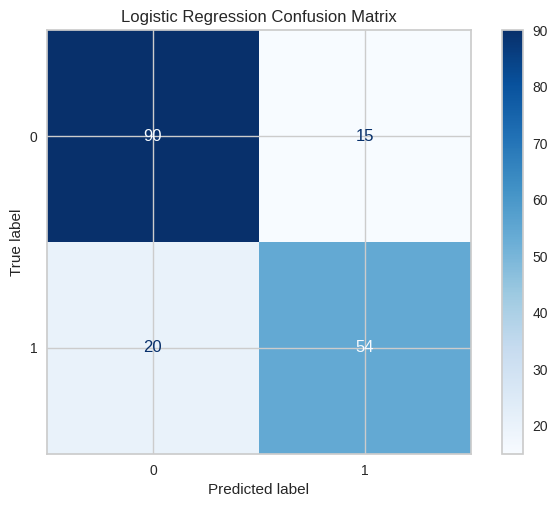

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP Accuracy: 0.7821
MLP F1 Score: 0.7273
MLP Precision: 0.7536
MLP ROC AUC: 0.8722
MLP Confusion Matrix:


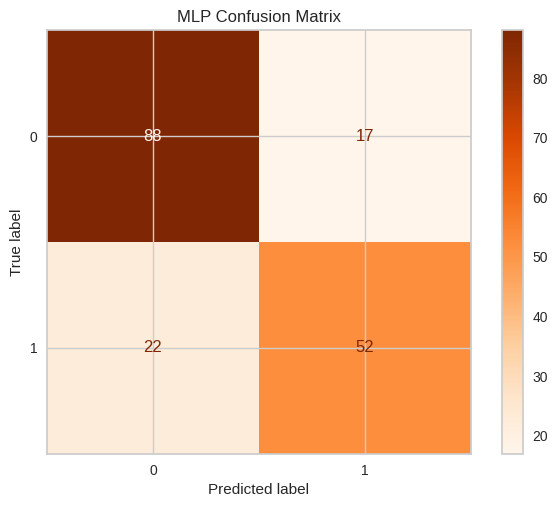

In [ ]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=200, random_state=42)
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_val)
log_reg_acc = accuracy_score(y_val, y_pred_log_reg)
log_reg_f1 = f1_score(y_val, y_pred_log_reg)
log_reg_precision = precision_score(y_val, y_pred_log_reg)
log_reg_roc_auc = roc_auc_score(y_val, log_reg.predict_proba(X_val)[:, 1])
log_reg_confusion = confusion_matrix(y_val, y_pred_log_reg)

print(f'Logistic Regression Accuracy: {log_reg_acc:.4f}')
print(f'Logistic Regression F1 Score: {log_reg_f1:.4f}')
print(f'Logistic Regression Precision: {log_reg_precision:.4f}')
print(f'Logistic Regression ROC AUC: {log_reg_roc_auc:.4f}')
print('Logistic Regression Confusion Matrix:')
disp_log_reg = ConfusionMatrixDisplay(confusion_matrix=log_reg_confusion)
disp_log_reg.plot(cmap=plt.cm.Blues)
plt.title("Logistic Regression Confusion Matrix")
plt.show()

# Multi-Layer Perceptron (MLP)
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=200, random_state=42)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_val)
mlp_acc = accuracy_score(y_val, y_pred_mlp)
mlp_f1 = f1_score(y_val, y_pred_mlp)
mlp_precision = precision_score(y_val, y_pred_mlp)
mlp_roc_auc = roc_auc_score(y_val, mlp.predict_proba(X_val)[:, 1])
mlp_confusion = confusion_matrix(y_val, y_pred_mlp)

print(f'MLP Accuracy: {mlp_acc:.4f}')
print(f'MLP F1 Score: {mlp_f1:.4f}')
print(f'MLP Precision: {mlp_precision:.4f}')
print(f'MLP ROC AUC: {mlp_roc_auc:.4f}')
print('MLP Confusion Matrix:')
disp_mlp = ConfusionMatrixDisplay(confusion_matrix=mlp_confusion)
disp_mlp.plot(cmap=plt.cm.Oranges)
plt.title("MLP Confusion Matrix")
plt.show()


# **Make Predictions and Submission**

In [ ]:
# Predict using the better model
best_model = log_reg if log_reg_acc > mlp_acc else mlp

# Prepare the test set
X_test = test_data[features]

# Make predictions
test_data['Survived'] = best_model.predict(X_test)

# Prepare submission file
submission = test_data[['PassengerId', 'Survived']]
submission.to_csv('submission.csv', index=False)
print('Submission file created successfully!')


Submission file created successfully!


The first submission of the code. **our conclusion is that we could improve our score in data preproccesing,feature selection and hyperparameter tuning**:
1. Enhanced data preprocessing with grouped median for age, created new features (FamilySize and IsAlone).
2. Updated feature selection to include new features.
3. Added hyperparameter tuning using GridSearchCV for both Logistic Regression and SGDClassifier.

These changes should help improve your model's performance by leveraging more informative features and optimizing model parameters.








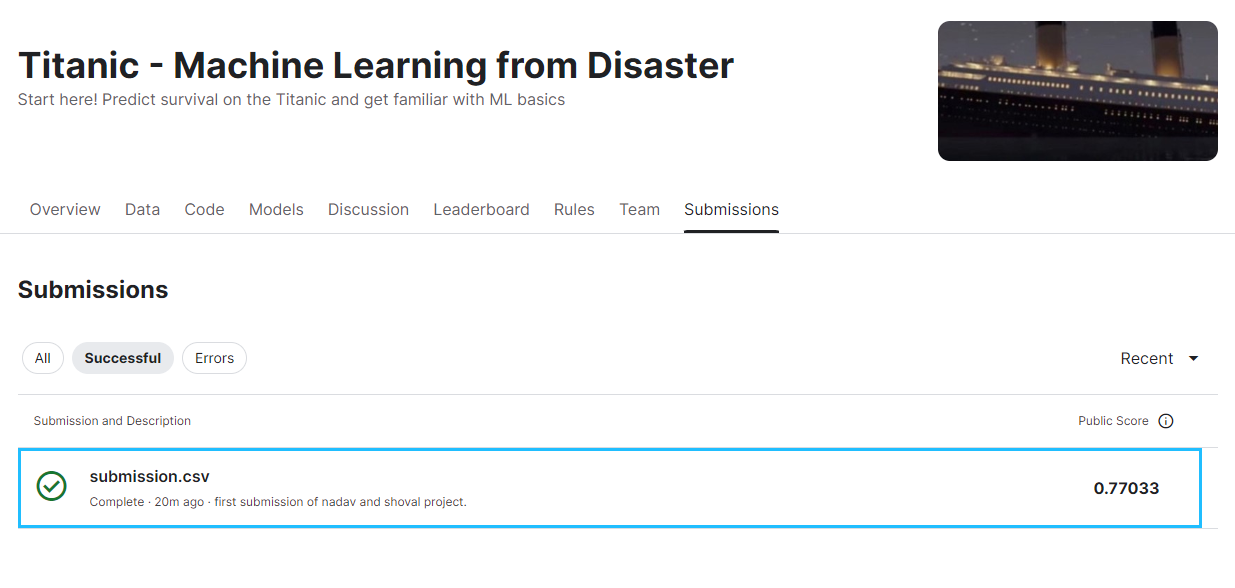

# **Model Training and Evaluation** - 2

In [ ]:
# Define the objective function for Optuna
def objective(trial):
    n_layers = trial.suggest_int('n_layers', 1, 2)
    layers = []
    for i in range(n_layers):
        layers.append(trial.suggest_int(f'n_units_l{i}', 10, 100))
    activation = trial.suggest_categorical('activation', ['identity', 'logistic', 'tanh', 'relu'])
    solver = trial.suggest_categorical('solver', ['lbfgs', 'sgd', 'adam'])
    alpha = trial.suggest_float('alpha', 1e-5, 1e-2, log=True)
    learning_rate = trial.suggest_categorical('learning_rate', ['constant', 'invscaling', 'adaptive'])

    model = MLPClassifier(hidden_layer_sizes=tuple(layers), activation=activation, solver=solver,
                          alpha=alpha, learning_rate=learning_rate, max_iter=200, random_state=42)

    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    train_acc = accuracy_score(y_train, y_pred_train)
    val_acc = accuracy_score(y_val, y_pred_val)

    train_loss = log_loss(y_train, model.predict_proba(X_train))
    val_loss = log_loss(y_val, model.predict_proba(X_val))

    trial.set_user_attr('train_acc', train_acc)
    trial.set_user_attr('train_loss', train_loss)
    trial.set_user_attr('val_loss', val_loss)

    return val_acc

# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

# Train the final model using the best hyperparameters
best_params = study.best_params
best_layers = tuple(best_params[f'n_units_l{i}'] for i in range(best_params['n_layers']))
best_mlp = MLPClassifier(hidden_layer_sizes=best_layers, activation=best_params['activation'],
                         solver=best_params['solver'], alpha=best_params['alpha'],
                         learning_rate=best_params['learning_rate'], max_iter=200, random_state=42)

best_mlp.fit(X_train, y_train)

# Predict on the validation set
y_pred_best = best_mlp.predict(X_val)
best_acc = accuracy_score(y_val, y_pred_best)
print(f'Best MLP Accuracy: {best_acc:.4f}')

# Make predictions on the test set
test_data['Survived'] = best_mlp.predict(X_test)

# Prepare submission file
submission = test_data[['PassengerId', 'Survived']]
submission.to_csv('submission.csv', index=False)
print('Submission file created successfully!')

# Collect training and validation losses and accuracies over different hyperparameters
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for trial in study.trials:
    train_accuracies.append(trial.user_attrs['train_acc'])
    val_accuracies.append(trial.value)
    train_losses.append(trial.user_attrs['train_loss'])
    val_losses.append(trial.user_attrs['val_loss'])

[I 2024-07-15 09:56:45,663] A new study created in memory with name: no-name-549beae2-e8b7-4dce-ba11-089f9a844a43
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
[I 2024-07-15 09:56:59,103] Trial 0 finished with value: 0.8100558659217877 and parameters: {'n_layers': 2, 'n_units_l0': 99, 'n_units_l1': 59, 'activation': 'tanh', 'solver': 'lbfgs', 'alpha': 0.0006594733208888371, 'learning_rate': 'invscaling'}. Best is trial 0 with value: 0.8100558659217877.
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS

Best hyperparameters:  {'n_layers': 2, 'n_units_l0': 99, 'n_units_l1': 59, 'activation': 'tanh', 'solver': 'lbfgs', 'alpha': 0.0006594733208888371, 'learning_rate': 'invscaling'}
Best MLP Accuracy: 0.8101
Submission file created successfully!


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


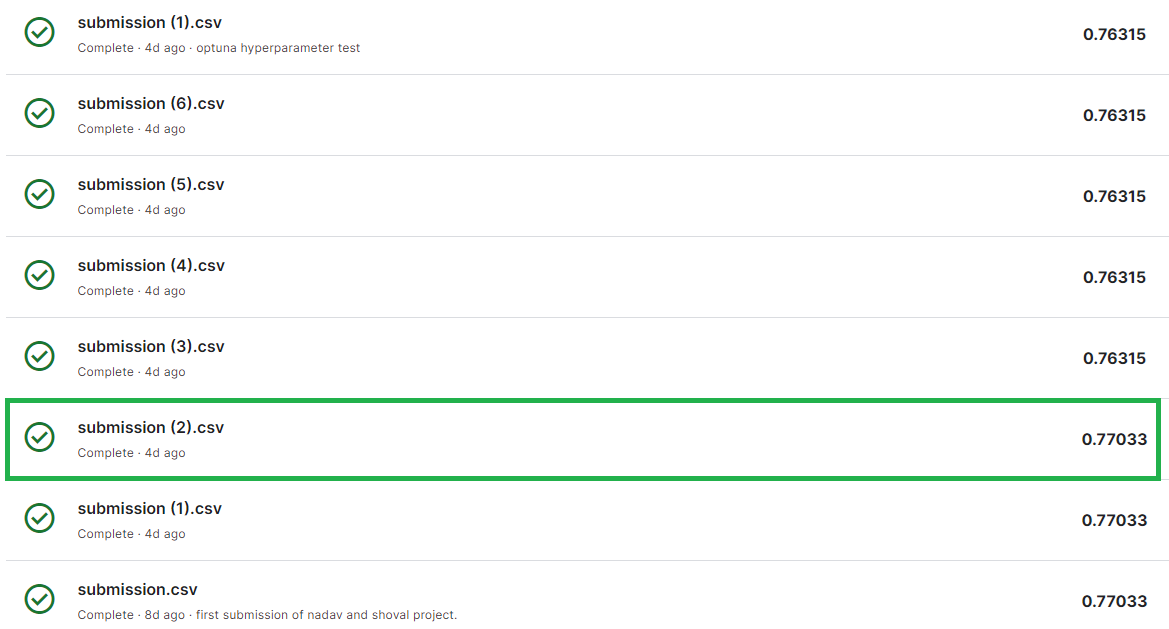

our intial model was better due to best fit the data and model selected for this assignment meaning the later optimized model had overfitting issues.

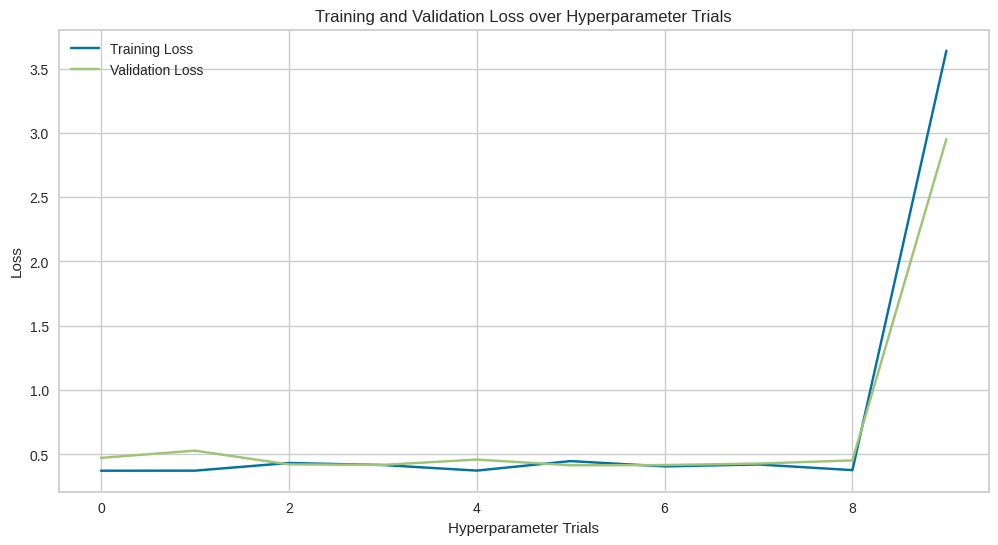

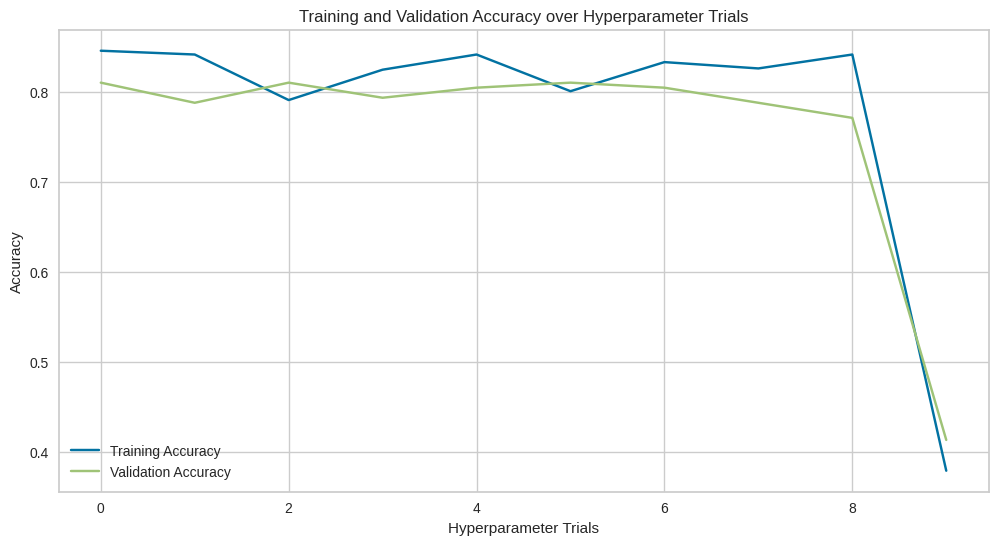

In [ ]:
# Collect training and validation losses and accuracies over different hyperparameters
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for trial in study.trials:
    train_accuracies.append(trial.user_attrs['train_acc'])
    val_accuracies.append(trial.value)
    train_losses.append(trial.user_attrs['train_loss'])
    val_losses.append(trial.user_attrs['val_loss'])

# Plot the training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Hyperparameter Trials')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Hyperparameter Trials')
plt.legend()
plt.show()

# Plot the training and validation accuracies
plt.figure(figsize=(12, 6))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Hyperparameter Trials')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Hyperparameter Trials')
plt.legend()
plt.show()

# **Comparison and Conclusion**

The graphs show the training and validation losses and accuracies over different hyperparameter trials. The training and validation metrics fluctuate significantly, indicating that some hyperparameter combinations overfit the training data while others underfit. Notably, some trials show close alignment between training and validation metrics, suggesting good generalization. Further fine-tuning of hyperparameters and feature selection is needed to stabilize and improve the model performance.

# **Bottom line:**
The trials indicate variability in performance due to different hyperparameter settings, with some models showing overfitting or underfitting. Continuous refinement and validation across diverse feature subsets are essential to achieve a robust model.








# **References**
Notebooks and Tutorials:

Kaggle Titanic Competition Notebooks: Various Kaggle notebooks provided inspiration and guidance on approaches to the Titanic dataset.
Example: Kaggle Titanic Notebook
Books:

"Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow" by Aurélien Géron: This book provided comprehensive coverage on various machine learning models, including MLP, and techniques for hyperparameter tuning.
Documentation:

Scikit-Learn Documentation: Detailed information on the MLPClassifier and other functions used in the project.
MLPClassifier Documentation
Hyperparameter Tuning with Optuna
Articles:

Articles on data preprocessing, feature selection, and model evaluation metrics.
Understanding Logistic Regression
Feature Selection Techniques

----
----
# **Phase 3 Adaptation**

#**Importing Libraries**

In [ ]:
!pip install --upgrade shap-hypetune
!pip install optuna

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.feature_selection import RFE, SelectKBest, f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, precision_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import VotingClassifier
import optuna
import lightgbm as lgb
from shaphypetune import BoostRFE, BoostRFA

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 966.0/966.0 kB 12.0 MB/s eta 0:00:00
  Attempting uninstall: hyperopt
    Found existing installation: hyperopt 0.2.7
    Uninstalling hyperopt-0.2.7:
      Successfully uninstalled hyperopt-0.2.7
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.6 MB/s eta 0:00:00


# **Loading and Preparing the Dataset**

We loaded the dataset, filled missing values with median/mode, combined train and test data for consistent encoding, and applied label encoding to categorical variables, except 'Name'. Finally, we separated the combined data back into train and test sets. This preprocessing ensures data consistency for later stages.








In [ ]:
# Load the dataset
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Preserve original PassengerId for submission
test_data_orig = test_data.copy()

# Fill missing values
for col in train_data.select_dtypes(include=[np.number]).columns:
    train_data[col].fillna(train_data[col].median(), inplace=True)
    if col in test_data.columns:
        test_data[col].fillna(train_data[col].median(), inplace=True)

for col in train_data.select_dtypes(include=['object']).columns:
    train_data[col].fillna(train_data[col].mode()[0], inplace=True)
    if col in test_data.columns:
        test_data[col].fillna(test_data[col].mode()[0], inplace=True)

# Combine train and test data for consistent encoding
train_data['is_train'] = 1
test_data['is_train'] = 0
combined_data = pd.concat([train_data, test_data])

# Encode categorical variables except for the 'Name' column
label_encoders = {}
for col in combined_data.select_dtypes(include=['object']).columns:
    if col != 'Name':
        le = LabelEncoder()
        combined_data[col] = le.fit_transform(combined_data[col].astype(str))
        label_encoders[col] = le

# Separate the combined data back into train and test sets
train_data = combined_data[combined_data['is_train'] == 1].drop(['is_train'], axis=1)
test_data = combined_data[combined_data['is_train'] == 0].drop(['is_train'], axis=1)